<a href="https://colab.research.google.com/github/hydro-7/Segmentation_Notebooks/blob/main/DLRSD_AUnet_Segmentation_Final_(25e).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Importing Dataset from Local System**

In [1]:
!unzip DLRSD.zip

Archive:  DLRSD.zip
  inflating: DLRSD/Images/agricultural/agricultural00.tif  
  inflating: DLRSD/Images/agricultural/agricultural01.tif  
  inflating: DLRSD/Images/agricultural/agricultural02.tif  
  inflating: DLRSD/Images/agricultural/agricultural03.tif  
  inflating: DLRSD/Images/agricultural/agricultural04.tif  
  inflating: DLRSD/Images/agricultural/agricultural05.tif  
  inflating: DLRSD/Images/agricultural/agricultural06.tif  
  inflating: DLRSD/Images/agricultural/agricultural07.tif  
  inflating: DLRSD/Images/agricultural/agricultural08.tif  
  inflating: DLRSD/Images/agricultural/agricultural09.tif  
  inflating: DLRSD/Images/agricultural/agricultural10.tif  
  inflating: DLRSD/Images/agricultural/agricultural11.tif  
  inflating: DLRSD/Images/agricultural/agricultural12.tif  
  inflating: DLRSD/Images/agricultural/agricultural13.tif  
  inflating: DLRSD/Images/agricultural/agricultural14.tif  
  inflating: DLRSD/Images/agricultural/agricultural15.tif  
  inflating: DLRSD/I

# **Importing Libraries**

In [2]:
import os

import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader, Subset
import torch.nn.functional as F
import torch.optim as optim

import torchvision
from torchvision import transforms, datasets, models

import cv2
import numpy as np
import matplotlib.pyplot as plt

from PIL import Image
import shutil

import requests
import zipfile
from pathlib import Path
from torch.utils.data import random_split

import random

from sklearn.model_selection import train_test_split

from tqdm.notebook import tqdm
from tqdm import tqdm

seed = 42

Setting up the device being used (gpu or cpu)

In [3]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

# **Initializing Image & Mask Directories**

Checking if the Dataset has been uploaded correctly, by checking the existance of the Image & Mask folders.

In [4]:
image_path = Path('/content/DLRSD/Images')
mask_path = Path('/content/DLRSD/Labels')

if image_path.is_dir():
    print(f"{image_path} directory exists.")
else:
    print("Khel khatam")

if mask_path.is_dir():
    print(f"{mask_path} directory exists.")
else:
    print("Khel khatam")

/content/DLRSD/Images directory exists.
/content/DLRSD/Labels directory exists.


Checking if there are any images in the image_path folders.



Random image path: /content/DLRSD/Images/forest/forest48.tif
Image class: forest
Image height: 256
Image width: 256


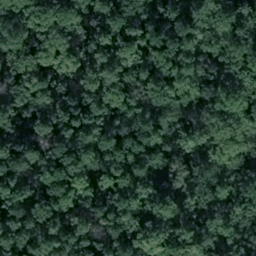

In [5]:
random.seed(seed)

# 1. Get all image paths (* means "any combination")

image_path_list = list(image_path.glob("*/*.tif"))

# 2. Get random image path
random_image_path = random.choice(image_path_list)

# 3. Get image class from path name (the image class is the name of the directory where the image is stored)
image_class = random_image_path.parent.stem

# 4. Open image
img = Image.open(random_image_path)

# 5. Print metadata
print(f"Random image path: {random_image_path}")
print(f"Image class: {image_class}")
print(f"Image height: {img.height}")
print(f"Image width: {img.width}")
img

Checking number of image classes.



In [6]:
image_class_list = list(image_path.glob("*"))
print(len(image_class_list))

21


Making sure that the number of images in the Images dir == number of masks in the Labels dir.



In [7]:
mask_path_list = list(mask_path.glob("*/*.png"))
print(len(mask_path_list) == len(image_path_list))

True


# **Data Preprocessing Steps**

Applying One Hot encoding to the data.

In [8]:
def load_and_preprocess_mask(path):


    img = Image.open(path).convert('RGB')  # Ensure image is in RGB mode


    transform = transforms.Compose([
        transforms.ToTensor()
    ])


    img_tensor = transform(img)


    img_np = img_tensor.numpy().transpose(1, 2, 0) * 255
    img_np = img_np.astype(np.uint8)

    return img_np

def load_and_preprocess_segment(path, img_size, colors):


    seg = load_and_preprocess_mask(path)


    mask = np.zeros((256, 256, len(colors)), dtype=np.uint8)


    for i, color in enumerate(colors):

        cmap = np.all(np.equal(seg, color), axis=-1)
        mask[:, :, i] = cmap * 1


    # mask = np.moveaxis(mask, -1, 0)

    mask_tensor = torch.tensor(mask, dtype=torch.float32).permute(2, 0, 1)  # Convert to CHW format

    return mask_tensor

In [9]:
IMG_SIZE1 = 256
IMG_SIZE2 = 256
colors = [
  [ 166 ,202, 240 ],
  [ 128, 128, 0 ],
  [ 0 ,0, 128 ],
  [ 255, 0 ,0 ],
  [ 0 ,128 ,0 ],
  [ 128 ,0, 0 ],
  [ 255 ,233 ,233 ],
  [ 160, 160, 164 ],
  [ 0 ,128 ,128],
  [ 90 ,87, 255],
  [ 255 ,255 ,0 ],
  [ 255, 192, 0 ],
  [ 0 ,0 ,255 ],
  [ 255 ,0 ,192 ],
  [ 128 ,0 ,128 ],
  [ 0 ,255, 0 ],
  [ 0 ,255 ,255 ]
]


In [10]:
path_to_mask = '/content/DLRSD/Labels/agricultural/agricultural00.png'
mask_tensor = load_and_preprocess_segment(path_to_mask, (256, 256), colors)
print(mask_tensor.shape)
print(mask_tensor) #One hot encoded mask

torch.Size([17, 256, 256])
tensor([[[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]],

        [[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]],

        [[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]],

        ...,

        [[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 

# **Making Dataloaders for Training & Testing**

In [11]:
class SegmentationDataset(Dataset):
    def __init__(self, image_dir, mask_dir,img_size):
        self.image_dir = image_dir
        self.mask_dir = mask_dir


        self.img_size = img_size

        self.images_classes = sorted(os.listdir(image_dir))
        self.masks_classes = sorted(os.listdir(mask_dir))
        self.image_paths=[]
        self.masks_paths=[]


        for clas in sorted(self.images_classes):
            self.image= sorted(os.listdir(os.path.join(self.image_dir,clas)))
            for idx in range(100):
                self.image_paths.append(os.path.join(self.image_dir,clas,self.image[idx]))


        for clas in sorted(self.masks_classes):
            self.mask= sorted(os.listdir(os.path.join(self.mask_dir,clas)))
            for idx in range(100):
                self.masks_paths.append(os.path.join(self.mask_dir,clas,self.mask[idx]).replace('.tif','.png'))


    def __len__(self):

        return len(self.images_classes)*100

    def __getitem__(self, idx):




        img = Image.open(self.image_paths[idx]).convert('RGB')
        img = img.resize(self.img_size)
        img = np.array(img) / 255.0  # Normalize to [0, 1]
        img = torch.tensor(img, dtype=torch.float32).permute(2, 0, 1)  # Convert to CHW format


        mask=load_and_preprocess_segment(self.masks_paths[idx],(256, 256), colors)

        return img, mask

In [12]:
img_size=(256,256)

In [17]:
dataset = SegmentationDataset(image_dir="/content/DLRSD/Images", mask_dir="/content/DLRSD/Labels", img_size=img_size)
dataloader = DataLoader(dataset, batch_size=8, shuffle=True)
indices = list(range(len(dataset)))
train_indices, test_indices = train_test_split(indices, test_size=0.2, random_state=42)


train_subset = Subset(dataset, train_indices)
test_subset = Subset(dataset, test_indices)

# train_dataloader = DataLoader(train_subset, batch_size=8, shuffle=True, num_workers=4)
# test_dataloader = DataLoader(test_subset, batch_size=8, shuffle=False, num_workers=4)

train_dataloader = DataLoader(train_subset, batch_size=8, shuffle=True)
test_dataloader = DataLoader(test_subset, batch_size=8, shuffle=False)

# **Attention Unet Architecture**

In [18]:
class attention_block(nn.Module):
    def __init__(self,g,x,i):
        super(attention_block,self).__init__()
        self.wg=nn.Conv2d(g,i,kernel_size=1,stride=1,padding=0)
        self.wx=nn.Conv2d(x,i,kernel_size=1,stride=1,padding=0)
        self.psi=nn.Sequential(
            nn.Conv2d(i,1,kernel_size=1,stride=1,padding=0),
            nn.Sigmoid()      )

    def forward(self,g,x):
        g1=self.wg(g)
        x1=self.wx(x)
        psi=nn.ReLU()(g1+x1)
        psi=self.psi(psi)
        return psi*x


class conv(nn.Module):
    def __init__(self,in_channels,out_channels):

        super(conv,self).__init__()
        self.conv2d=nn.Sequential(
        nn.Conv2d(in_channels,out_channels,kernel_size=3,padding=1),
        nn.ReLU(),
        nn.Conv2d(out_channels,out_channels,kernel_size=3,padding=1),
        nn.ReLU()
        )
    def forward(self,x):

        x=self.conv2d(x)
        return x

class upconv(nn.Module):
    def __init__(self,in_channels,out_channels):
        super(upconv,self).__init__()
        self.up=nn.Sequential(
        nn.ConvTranspose2d(in_channels, out_channels, kernel_size=2, stride=2)

        )

    def forward(self,x):
        x=self.up(x)
        return x

class Attention_Unet(nn.Module):
    def __init__(self,in_channels,out_channels):
        super(Attention_Unet,self).__init__()
        self.in_channels=in_channels
        self.out_channels=out_channels

        self.e1=conv(in_channels,out_channels=64)
        self.e2=conv(in_channels=64,out_channels=128)
        self.e3=conv(in_channels=128,out_channels=256)
        self.e4=conv(in_channels=256,out_channels=512)
        self.e5=conv(in_channels=512,out_channels=1024)

        self.max=nn.MaxPool2d(kernel_size=2,stride=2)

        self.d1=upconv(in_channels=1024,out_channels=512)
        self.att1= attention_block(g=512,x=512,i=256)
        self.up_conv1=conv(in_channels=1024,out_channels=512)

        self.d2=upconv(in_channels=512,out_channels=256)
        self.att2= attention_block(g=256,x=256,i=128)
        self.up_conv2=conv(in_channels=512,out_channels=256)

        self.d3=upconv(in_channels=256,out_channels=128)
        self.att3= attention_block(g=128,x=128,i=64)
        self.up_conv3=conv(in_channels=256,out_channels=128)

        self.d4=upconv(in_channels=128,out_channels=64)
        self.att4= attention_block(g=64,x=64,i=32)
        self.up_conv4=conv(in_channels=128,out_channels=64)

        self.conv1x1=nn.Conv2d(64,out_channels,kernel_size=1)


    def forward(self,x):
        #encoding
        x1=self.e1(x)
        x2=self.max(x1)

        x2=self.e2(x2)
        x3=self.max(x2)

        x3=self.e3(x3)
        x4=self.max(x3)

        x4=self.e4(x4)
        x5=self.max(x4)

        x5=self.e5(x5)

        #decoding

        y1=self.d1(x5)
        x4=self.att1(y1,x4)
        y1 = torch.cat((x4,y1),dim=1)
        y1=self.up_conv1(y1)

        y2=self.d2(y1)
        x3=self.att2(y2,x3)
        y2 = torch.cat((x3,y2),dim=1)
        y2=self.up_conv2(y2)

        y3=self.d3(y2)
        x2=self.att3(y3,x2)
        y3 = torch.cat((x2,y3),dim=1)
        y3=self.up_conv3(y3)

        y4=self.d4(y3)
        x1=self.att4(y4,x1)
        y4 = torch.cat((x1,y4),dim=1)
        y4=self.up_conv4(y4)

        y5=self.conv1x1(y4)
        return y5


model=Attention_Unet(3, 17) # 3 input & 17 output channels (17 categories in dlrsd)
model.to(device) # send model to gpu

Attention_Unet(
  (e1): conv(
    (conv2d): Sequential(
      (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU()
      (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (3): ReLU()
    )
  )
  (e2): conv(
    (conv2d): Sequential(
      (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU()
      (2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (3): ReLU()
    )
  )
  (e3): conv(
    (conv2d): Sequential(
      (0): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU()
      (2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (3): ReLU()
    )
  )
  (e4): conv(
    (conv2d): Sequential(
      (0): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU()
      (2): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (3): ReLU()
    )
  )
  (e5): conv(


# **Defining Loss function & Optimizer**

In [19]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)

# **Training Loop**

In [20]:
torch.manual_seed(32)
num_epochs = 25

model.train()

for epoch in range(num_epochs):
    # model.train()
    running_loss = 0.0

    for X, Y in tqdm(train_dataloader, total = len(train_dataloader), leave = False):
        optimizer.zero_grad()

        X,Y= X.to(device),Y.to(device)
        # Forward pass

        outputs = model(X)


        # Convert one-hot masks to class indices
        targets = Y.argmax(dim=1)

        # Compute loss
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * X.size(0)

    epoch_loss = running_loss / len(dataloader.dataset)
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}')

print("Training complete!")

Epoch [1/25], Loss: 1.9626


Epoch [2/25], Loss: 1.8164


Epoch [3/25], Loss: 1.7109


Epoch [4/25], Loss: 1.6601


Epoch [5/25], Loss: 1.6203


Epoch [6/25], Loss: 1.5758


Epoch [7/25], Loss: 1.5244


Epoch [8/25], Loss: 1.4932


Epoch [9/25], Loss: 1.3988


Epoch [10/25], Loss: 1.3127


Epoch [11/25], Loss: 1.2653


Epoch [12/25], Loss: 1.2273


Epoch [13/25], Loss: 1.2014


Epoch [14/25], Loss: 1.1694


Epoch [15/25], Loss: 1.1368


Epoch [16/25], Loss: 1.1246


Epoch [17/25], Loss: 1.0847


Epoch [18/25], Loss: 1.0708


Epoch [19/25], Loss: 1.0316


Epoch [20/25], Loss: 1.0144


Epoch [21/25], Loss: 0.9854


Epoch [22/25], Loss: 0.9561


Epoch [23/25], Loss: 0.9296


Epoch [24/25], Loss: 0.9010


Epoch [25/25], Loss: 0.8846
Training complete!


# **Calculating IOU Score**

In [23]:
import torchmetrics
from torchmetrics.classification import MulticlassJaccardIndex

In [24]:
num_classes=17
jaccard_metric = MulticlassJaccardIndex(num_classes=num_classes).to(device)

In [25]:
torch.manual_seed(32)
model.eval()

with torch.no_grad():
    jaccard_scores_list = []

    for X, Y in test_dataloader:
        X, Y = X.to(device), Y.to(device)

        y_pred = model(X)
        Y = torch.argmax(Y, dim=1)

        batch_jaccard = jaccard_metric(y_pred, Y)
        print(batch_jaccard.item())
        jaccard_scores_list.append(batch_jaccard.item())


average_jaccard = sum(jaccard_scores_list) / len(jaccard_scores_list)
print(f"Mean Jaccard Index (IoU) over the test dataset: {average_jaccard:.4f}")

0.3774365782737732
0.27299755811691284
0.3915243148803711
0.31805580854415894
0.3246021270751953
0.26755455136299133
0.2970111668109894
0.24727237224578857
0.20551273226737976
0.3677687644958496
0.1841374635696411
0.2549290955066681
0.4187104403972626
0.25283336639404297
0.21927623450756073
0.2531527578830719
0.2744845151901245
0.26751112937927246
0.1960371881723404
0.23588405549526215
0.29841601848602295
0.23373933136463165
0.33122238516807556
0.1657809317111969
0.23685505986213684
0.27182215452194214
0.2883467972278595
0.24629999697208405
0.27030396461486816
0.3531727194786072
0.482639342546463
0.17464320361614227
0.2841741442680359
0.24327659606933594
0.23359563946723938
0.17162570357322693
0.2968897819519043
0.3727862536907196
0.27269598841667175
0.22304683923721313
0.33747076988220215
0.27935540676116943
0.39498206973075867
0.3282535672187805
0.2815935015678406
0.14364150166511536
0.2217702716588974
0.2843813896179199
0.27439361810684204
0.299250066280365
0.26472195982933044
0.348

# **Visualization of the Segmentation**

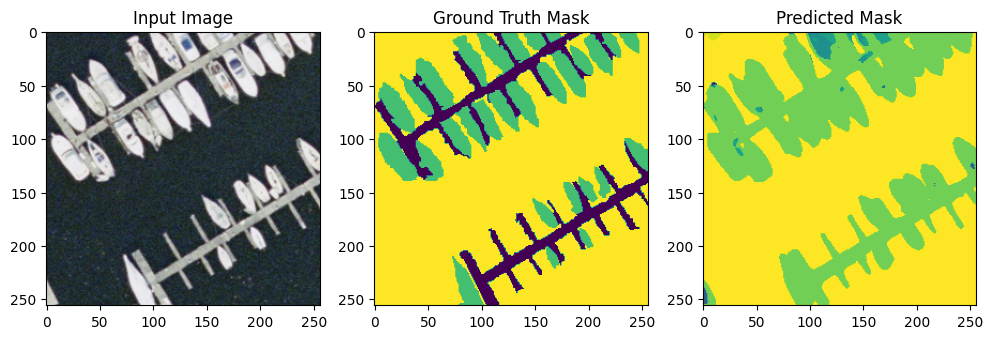

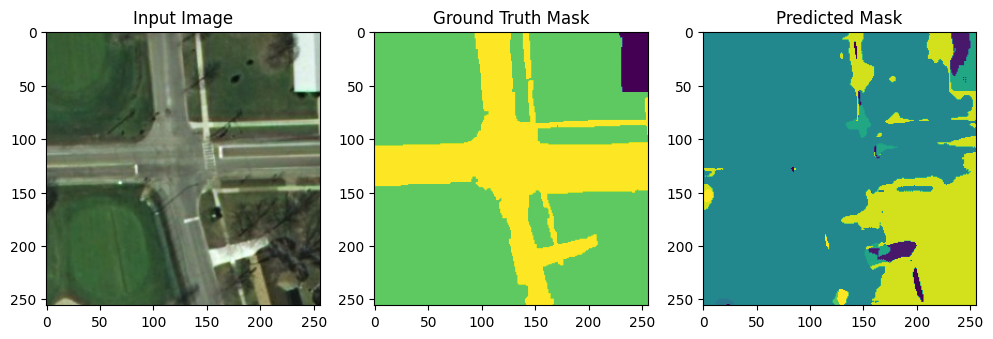

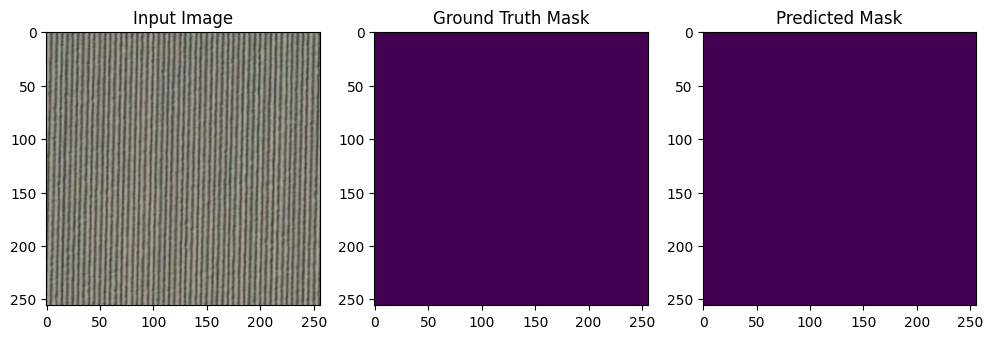

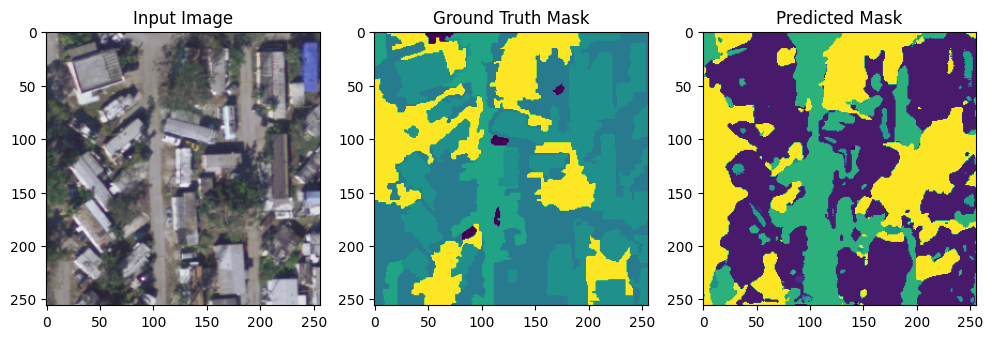

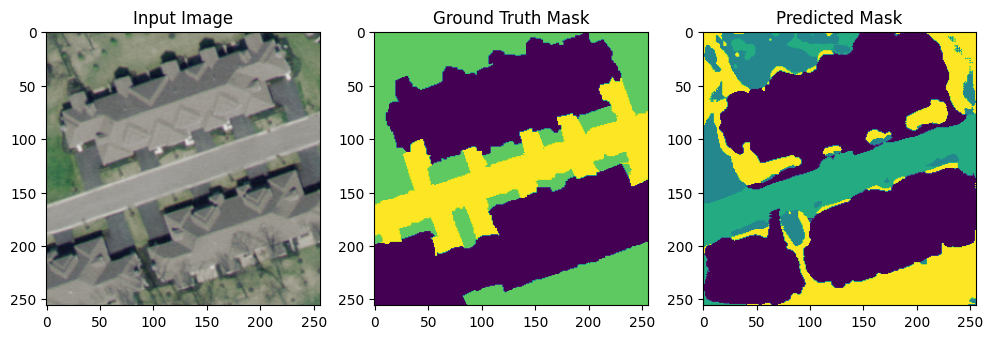

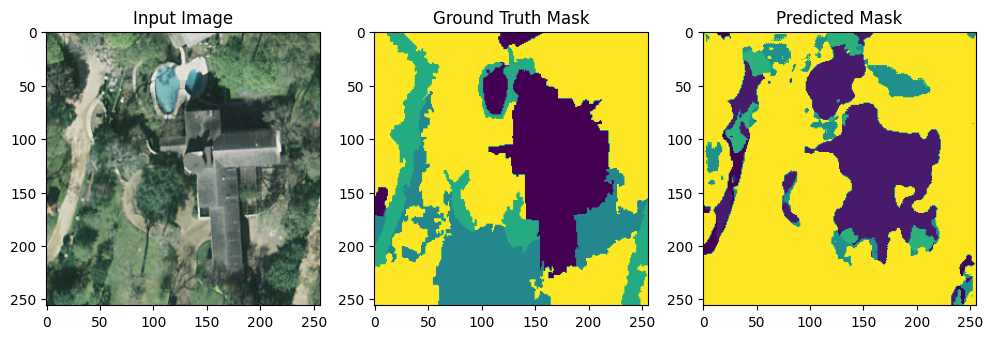

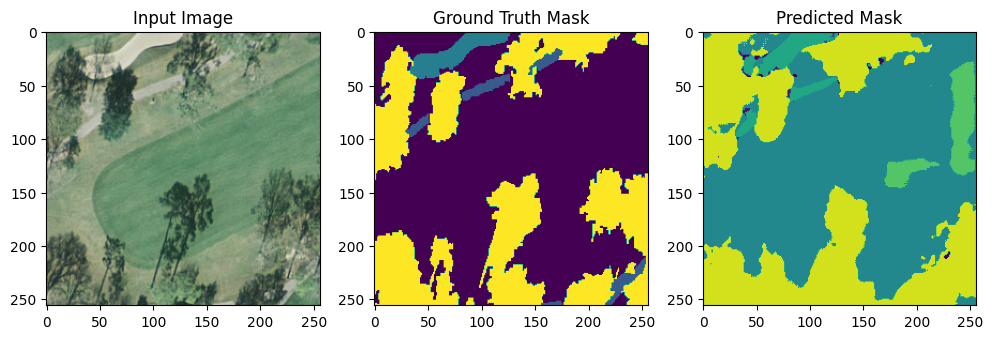

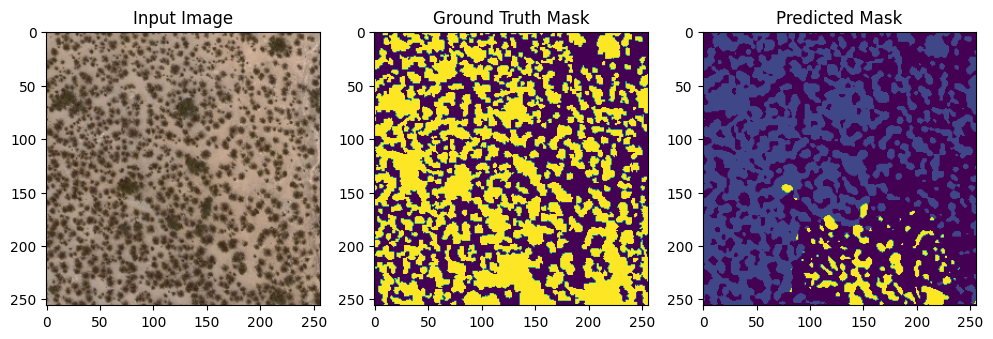

In [26]:
def visualize_segmentation(model, dataloader, device):
    model.eval()

    with torch.no_grad():
        for batch in dataloader:
            images, masks = batch
            images, masks = images.to(device), masks.to(device)

            preds = model(images)
            preds = torch.argmax(preds, dim=1)  # Get the class with the highest probability

            images_np = images.cpu().numpy().transpose(0, 2, 3, 1)  # Convert to HWC format
            masks_np = torch.argmax(masks, dim=1).cpu().numpy()     # Convert one-hot to class indices
            preds_np = preds.cpu().numpy()

            batch_size = images_np.shape[0]

            for i in range(batch_size):
                plt.figure(figsize=(12, 6))

                # Input image
                plt.subplot(1, 3, 1)
                plt.imshow(images_np[i])
                plt.title("Input Image")

                # Ground truth mask (class index for each pixel)
                plt.subplot(1, 3, 2)
                plt.imshow(masks_np[i])
                plt.title("Ground Truth Mask")

                # Predicted mask (class index for each pixel)
                plt.subplot(1, 3, 3)
                plt.imshow(preds_np[i])
                plt.title("Predicted Mask")

                plt.show()
            break  # Display only one batch for simplicity

# Now call the function to visualize
visualize_segmentation(model, test_dataloader, device)